# Transfer Learning - Cats x Dogs

## IMPORTANDO AS BIBLIOTECAS

In [1]:
%matplotlib inline

import os

import tensorflow as tf
import numpy as np
import keras
import requests

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image

from os import listdir
from os.path import isdir

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import layers
from keras import models
from keras import optimizers
from io import BytesIO

## BAIXANDO E EXTRAINDO O DATASET

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [3]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats


## DEFINIÇÃO DE VARIÁVEIS IMPORTANTES

In [4]:
IMAGE_SIZE = [220, 220]
EPOCHS = 60
CLASSES = 2
BATCH_SIZE = 32
INPUT_SHAPE = (220,220,3)
alpha = 1e-5
random_state = 42

## DIRETÓRIOS TRAIN E VALIDATION

#### O conteúdo .zip é extraído para o diretório `/root/.keras/datasets/cats_and_dogs_filtered` que contém os subdiretórios `train` e `validation` para os conjuntos de dados de treinamento e validação, que por sua vez contém os subdiretórios `cats` e `dogs`. Vamos definir cada um desses diretórios:

In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # diretório com fotos de gatos para treinamento
train_dogs_dir = os.path.join(train_dir, 'dogs')  # diretório com fotos de cachorros para treinamento
validation_cats_dir = os.path.join(validation_dir, 'cats')  # diretório com fotos de gatos para validação
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # diretório com fotos de cachorros para validação

#### Vamos ver como são os nomes de arquivo nos diretórios cats e dogs train (as convenções de nomenclatura são as mesmas no diretório validation):

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:5])

train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:5])

['cat.567.jpg', 'cat.483.jpg', 'cat.774.jpg', 'cat.810.jpg', 'cat.334.jpg']
['dog.5.jpg', 'dog.63.jpg', 'dog.418.jpg', 'dog.290.jpg', 'dog.401.jpg']


#### Agora, vamos descobrir o número de imagens de gatos e cachorros nos diretórios `train` e `validation`:

In [7]:
print('Total de imagens de gatos para treinamento:     ', len(os.listdir(train_cats_dir)))
print('Total de imagens de cachorros para treinamento: ', len(os.listdir(train_dogs_dir)))
print('Total de imagens de gatos para validação:       ', len(os.listdir(validation_cats_dir)))
print('Total de imagens de cachorros para validação:   ', len(os.listdir(validation_dogs_dir)))

print('\nTotal de imagens para treinamento: ', len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))
print('Total de imagens para validação:   ', len(os.listdir(validation_cats_dir)) + len(os.listdir(validation_dogs_dir)))

Total de imagens de gatos para treinamento:      1000
Total de imagens de cachorros para treinamento:  1000
Total de imagens de gatos para validação:        500
Total de imagens de cachorros para validação:    500

Total de imagens para treinamento:  2000
Total de imagens para validação:    1000


#### Para cães e gatos, temos 1.000 imagens de treinamento (totalizando 2.000) e 500 imagens de teste (totalizando 1.000). 

#### Vamos dar uma olhada em algumas fotos para ter uma idei melhor de como são os conjuntos de dados de cães e gatos. Primeiro, configuramos os parâmetros do matplotlib:

In [8]:
# Parâmetros para o gráfico; as imagens serão geradas em uma configuração 4x4
nrows = 4
ncols = 4

# Índice para iterar imagens
pic_index = 0

#### Agora, exibimos um lote de 8 fotos de gatos e 8 de cães. A célula poderá ser executada novamente para ver um novo lote a cada vez:

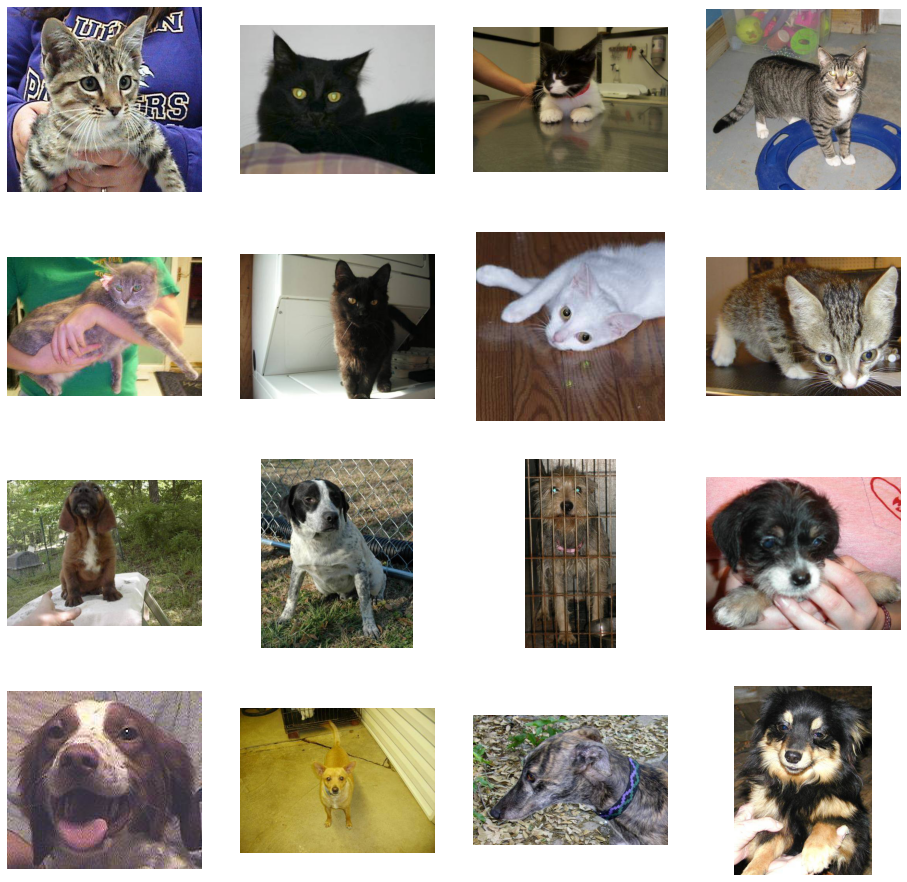

In [9]:
# Configura o matplotlib fig e dimensiona para caber em fotos 4x4
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pic = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pic = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pic + next_dog_pic):
    # Configura subtrama; os índices do subplot começam em 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')  # Não mostrar eixos (ou linhas de grade)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()            

## CALLBACKS

O ModelCheckpoint irá ajudar a salvar o modelo de cada época para assim não nos preocuparmos com possíveis problemas (como por exemplo travamento de máquina).

- filepath: onde o modelo será salvo
- monitor: métrica que será monitorada
- verbose: definirá se a barra de tarefas será ou não mostrada (1/0)
- save_best_only: Salvará somente o melhor modelo
- node: Forçará a extrair a melhor acurácia

In [10]:
filepath = 'transferlearning_weights.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, node='max')

### ReduceLROnPlateau

O ReduceLROnPlateau nos auxilia a reduzir a taxa de aprendizado caso não ocorra mudança no LOS.
- factor: fator de redução caso estejamos em um plator
- min_delta: valor mínimo de perda
- patience: só altere pelo fator após se repetir por 'patience' vezes
- verbose: mostrar a barra de progresso (1/0)

In [11]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=alpha, patience=5, verbose=1)

### Array de Callbacks

In [12]:
callbacks = [checkpoint, lr_reduce]

### Data Augmentation

#### Carregando imagens de treino

In [13]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

Found 2000 images belonging to 2 classes.


#### Carregando imagens de validação

In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

Found 1000 images belonging to 2 classes.


## TRANSFER LEARNING

### Modelo

In [16]:
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [17]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 226, 226, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 110, 110, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### Criação e sumarização do modelo:

In [18]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(CLASSES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1

#### Compilação e otimização do modelo:

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


#### Treinamento do modelo e armazenamento do histórico:

In [20]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    shuffle=True,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/60
63/63 [==============================] - ETA: 0s - loss: 0.5931 - acc: 0.6900
Epoch 1: val_acc improved from -inf to 0.50000, saving model to transferlearning_weights.hdf5
63/63 [==============================] - 48s 613ms/step - loss: 0.5931 - acc: 0.6900 - val_loss: 1.1570 - val_acc: 0.5000 - lr: 1.0000e-04
Epoch 2/60
63/63 [==============================] - ETA: 0s - loss: 0.2853 - acc: 0.8810
Epoch 2: val_acc did not improve from 0.50000
63/63 [==============================] - 35s 560ms/step - loss: 0.2853 - acc: 0.8810 - val_loss: 0.7102 - val_acc: 0.4980 - lr: 1.0000e-04
Epoch 3/60
63/63 [==============================] - ETA: 0s - loss: 0.1898 - acc: 0.9300
Epoch 3: val_acc improved from 0.50000 to 0.52300, saving model to transferlearning_weights.hdf5
63/63 [==============================] - 36s 576ms/step - loss: 0.1898 - acc: 0.9300 - val_loss: 0.7872 - val_acc: 0.5230 - lr: 1.0000e-04
Epoch 4/60
63/63 [==============================] - ETA: 0s - loss: 0.1756 - ac

#### Salvamento do modelo:

In [21]:
model.save('cats_and_dogs_filtered.h5')

#### Plotagem da acurácia do modelo de acordo com as EPOCHS:

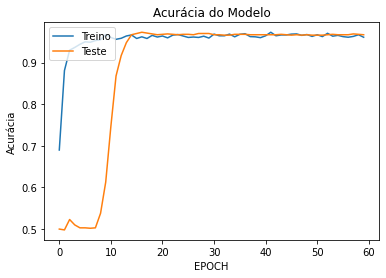

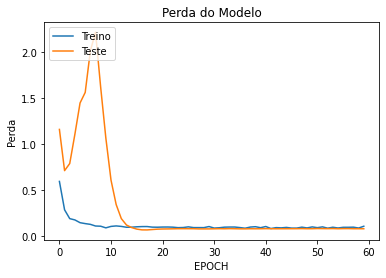

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Acurácia do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('EPOCH')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# Sumarização do histórico de perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Perda do Modelo')
plt.ylabel('Perda')
plt.xlabel('EPOCH')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

### Carregando imagens de teste

In [36]:
test_images = [
    'https://www.petz.com.br/blog/wp-content/uploads/2019/05/cachorro-independente-1.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2019/05/cachorro-independente-2.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/09/como-socializar-gatos-com-outros-gatos.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/09/como-socializar-gatos-com-outros-gatos-3.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/10/cao-mais-perigoso-do-mundo.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/10/como-dar-banho-em-gato-bravo-2.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/10/cao-mais-perigoso-do-mundo.jpg',
    'https://www.petz.com.br/blog/wp-content/uploads/2022/09/linguagem-corporal-do-gato-2.jpg'
]

test_labels = [1, 1, 0, 0, 1, 0, 1, 0]  # 1 --> Cachorro; 0 --> Gato

1/1 [==============================] - 0s 21ms/step


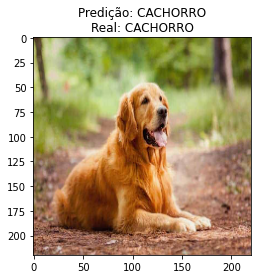

1/1 [==============================] - 0s 21ms/step


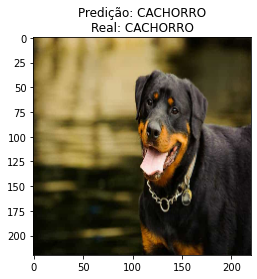

1/1 [==============================] - 0s 21ms/step


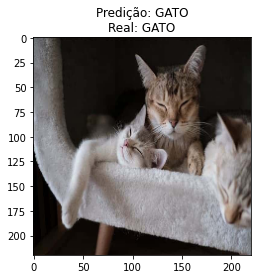

1/1 [==============================] - 0s 24ms/step


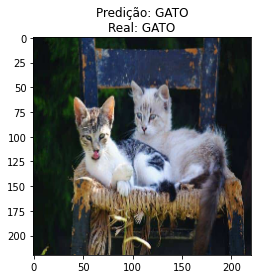

1/1 [==============================] - 0s 21ms/step


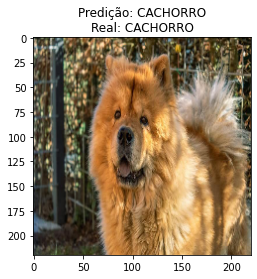

1/1 [==============================] - 0s 30ms/step


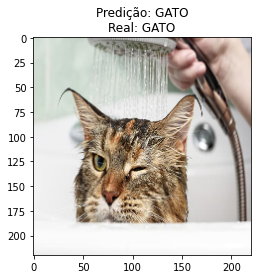

1/1 [==============================] - 0s 24ms/step


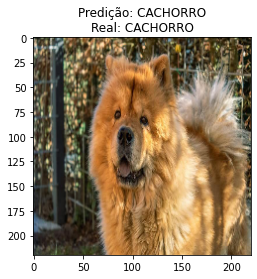

1/1 [==============================] - 0s 21ms/step


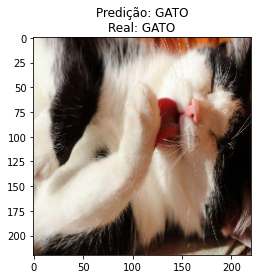

In [37]:
for (i,l) in enumerate(test_labels):
    response = requests.get(test_images[i])
    img = Image.open(BytesIO(response.content))
    img = np.asanyarray(img)/255.
    img = tf.image.resize(img, [IMAGE_SIZE[0], IMAGE_SIZE[1]])
    img = tf.reshape(img, (1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    prediction = model.predict(img)
    output = np.argmax(prediction)

    label = ['GATO', 'CACHORRO']
    plt.title(f'Predição: {label[output]}\nReal: {label[test_labels[i]]}')
    plt.imshow(img[0, ...])
    plt.show()